`Martín Alexis Martínez Andrade`

**This notebook was made in Google Colab.**

# P5: Linear Models & Correlation

Generate a linear model from the dataset, create graphs and obtain its R2 score.

## (Optional) Download modified_clean_data.csv from Dropbox

In [ ]:
# download file from dropbox
# !wget -O modified_clean_data.csv https://www.dropbox.com/scl/fi/8pnm0884bksvfcyxep4ec/modified_clean_data.csv?rlkey=n8qd7e299e1bydtfiwemsdeig&st=89yik26c&dl=1

## Load dataset

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os

df = pd.read_csv(f"modified_clean_data.csv")

## Linear model function

In [47]:
def perform_linear_regression(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    X = df[[x_col]]
    y = df[y_col]
    # discard nulls
    mask = X.notnull().all(axis=1) & y.notnull()

    X, y = X[mask], y[mask]

    lm = LinearRegression().fit(X, y)
    print(f"{x_col} vs. {y_col}")
    print(f'R^2: {lm.score(X, y):.4f}, Coefficient: {lm.coef_[0]:.5f}')
    plt.scatter(X, y, alpha=0.2)
    plt.plot(X, lm.predict(X), color='red')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

## What should we create a linear model for?

Let's see all of the variables we have, maybe we can have an initial hypothesis on linearity.

In [48]:
print(df.dtypes)

Id                          int64
ProductId                  object
UserId                     object
ProfileName                object
HelpfulnessNumerator        int64
HelpfulnessDenominator      int64
Score                       int64
Timestamp                   int64
Summary                    object
Text                       object
Date                       object
HelpfulnessScore          float64
ReviewLength                int64
LengthCategory             object
dtype: object


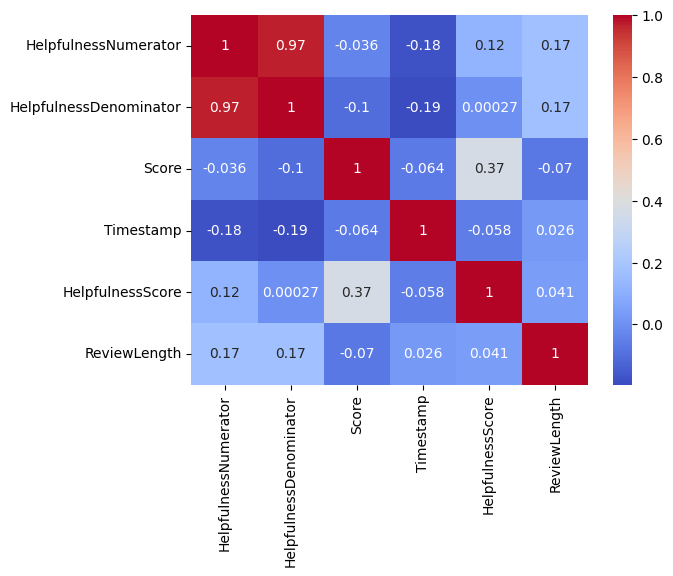

In [49]:
# correlation matrix in numerical columns (HelpfulnessNumerator, Denominator, Score, Timestamp, HelpfulnessScore and ReviewLength)
corr = df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Timestamp', 'HelpfulnessScore', 'ReviewLength']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Now, as you will realize later, there isn't a single linear relationship with the current variables. The highest $R^2$ gotten was $0.1$.

So, I had to experiment with *review text complexity vs helpfulness score* and *review text sentiment vs helpfulness score*. For shortness, in this practice I show the current variables' failed linear models and a linear model for the sentiment rating extracted by BERT model (TextBlob and VADER Sentiment were both tested, and their $R^2$ was around $0$).

Still, $R^2$ for *review text sentiment vs helpfulness score* is low ($R^2 ≃ 0.17$), but it's at least stronger than any of the other linear relationships.

## Testing relationships with our current variables

First, let's test if the amount of reviews a product has keeps a linear relationship with the amount of days passed since its first review. This might be useful to predict consumer interactions in the form of reviews, projecting since the first review made.

Amount of reviews of a product vs Amount of days passed since its first review
R^2: 0.1062
Coefficient: 0.0098 reviews/day


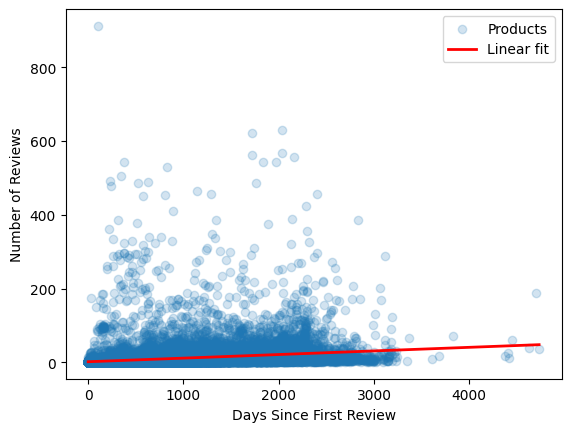

In [50]:
# Parse to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by product, get first and last review date, and count reviews
agg = df.groupby('ProductId').agg(
    first_review=('Date', 'min'),
    last_review=('Date', 'max'),
    n_reviews=('ProductId', 'count')
)

# Compute elapsed days from first to last review
agg['days_elapsed'] = (agg['last_review'] - agg['first_review']).dt.days

X = agg[['days_elapsed']]
y = agg['n_reviews']

lm = LinearRegression().fit(X, y)
print(f'Amount of reviews of a product vs Amount of days passed since its first review')
print(f'R^2: {lm.score(X, y):.4f}')
print(f'Coefficient: {lm.coef_[0]:.4f} reviews/day')

# Plot
plt.scatter(X, y, alpha=0.2, label='Products')
plt.plot(X, lm.predict(X), color='red', linewidth=2, label='Linear fit')
plt.xlabel('Days Since First Review')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

$R^2 ≃ 0.1$ indicates a really weak linear relationship.

Now, let's test if reviews with more votes tend to be more useful to other users. Let's use the helpfulness denominator (amount of votes) and the helpfulness score (positive votes / amount of votes).

HelpfulnessDenominator vs. HelpfulnessScore
R^2: 0.0000, Coefficient: 0.00001


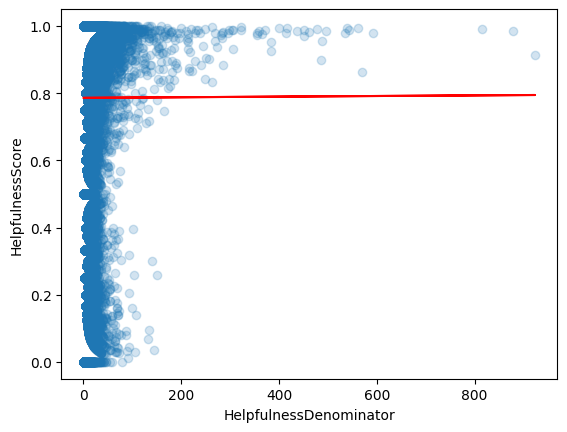

In [51]:
perform_linear_regression(df, 'HelpfulnessDenominator', 'HelpfulnessScore')

There's an amazing $R^2$ of $0$. There's no linear relationship between number of votes and helpfulness of a review *at all*.

Now, let's test if there's a linear relationship between the length of a review and its helpfulness score.

ReviewLength vs. HelpfulnessScore
R^2: 0.0017, Coefficient: 0.00003


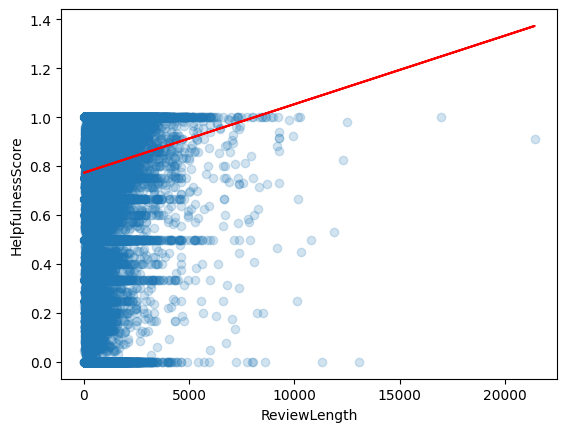

In [52]:
# use linear model func
perform_linear_regression(df, 'ReviewLength', 'HelpfulnessScore')

There's an incredibly low linear relationship of $R^2 ≃ 0.0017$ between the length of a review and its helpfulness.

Let's change our approach.

## Review sentiment vs Helpfulness Score

We now have to resort to exploring totally different relationships.

We'll do a sentiment analysis on the text of the reviews, and try to find a linear relationship with how helpful the review is.

In [53]:
# keep only reviews with N or more votes
n_votes_threshold = 10
df_filtered = df[df['HelpfulnessDenominator'] >= n_votes_threshold]
print(f"Reviews kept (reviews with {n_votes_threshold} or more votes): {df_filtered.shape[0]}")

Reviews kept (reviews with 10 or more votes): 17470


First, I used `TextBlob`. The results were poor, due to the lack of information captured by TextBlob's sentiment analysis.

!pip install textblob

In [54]:
from textblob import TextBlob

df_sampled = df_filtered.copy()

df_sampled['Sentiment'] = df_sampled['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

Sentiment vs. HelpfulnessScore
R^2: 0.0543, Coefficient: 0.32880


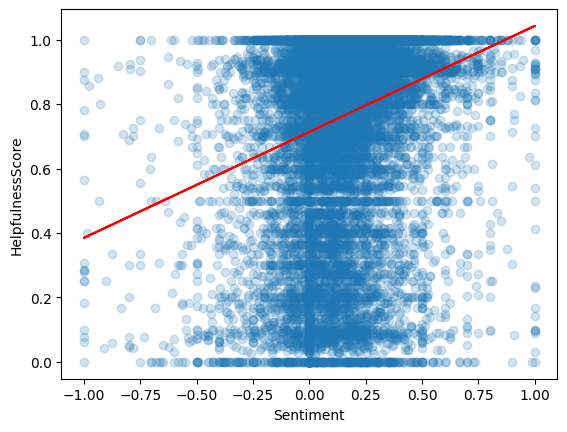

In [55]:
# use linear model func
perform_linear_regression(df_sampled, 'Sentiment', 'HelpfulnessScore')

$R^2 ≃ 0.05$ indicates a really weak linear relationship using TextBlob for sentiment analysis.

Then, `vaderSentiment` was used. Here's the code:

!pip install vaderSentiment

Sentiment vs. HelpfulnessScore
R^2: 0.1250, Coefficient: 0.17884


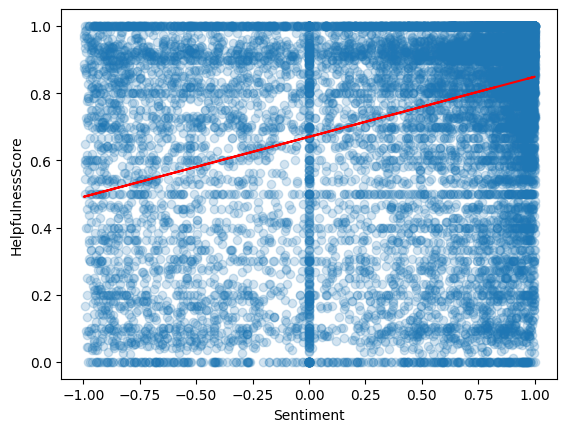

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(str(text))
    return vs['compound']  # [-1 ... 1], best as continuous variable

df_sampled = df_filtered.copy().dropna(subset=['Text'])
df_sampled['Sentiment'] = df_sampled['Text'].apply(get_vader_sentiment)

perform_linear_regression(df_sampled, 'Sentiment', 'HelpfulnessScore')

There's a weak relationship ($R^2 ≃ 0.125$), but stronger than any other previous relationship we've tested so far. It seems like there's a dense area in the top-right corner, which indicates reviews with really positive sentiment usually have high helpfulness scores. Still, there are a lot of datapoints across all sentiment values and helpfulness score values, so it's not a really strong relationship.

### Using absurd amounts of computing (BERT)

So far, the best $R^2$ is $0.125$, gotten by VADER Sentiment analysis.

Now, running the next code is optional and not recommended unless you can use a GPU. The code was run in Google Colab, so a (free!) T4 GPU was used and the analysis lasted a few seconds; using a CPU, it might take several minutes (in CPU-only Colab, it takes up to 60 minutes).

You can see the results gotten with BERT in the notebook (`.ipynb` file).

### (Input 'no' if you don't have a cuda-capable GPU unless you have 60 minutes of patience)

!pip install transformers torch tqdm

Execute BERT for sentiment analysis (yes/no)? WARNING: Might take up to 30 minutes on a CPU (a few seconds on a T4 GPU). It's recommended to enter 'no' if you don't have a cuda-capable GPU, and you'll get the exact same result showed in the notebook (if you keep the random_state=73).
*: yes
Reviews sampled: 2000


Device set to use cuda:0
BERT sentiment: 100%|██████████| 2000/2000 [00:22<00:00, 90.49it/s]


SentimentNormalized vs. HelpfulnessScore
R^2: 0.1619, Coefficient: 0.30777


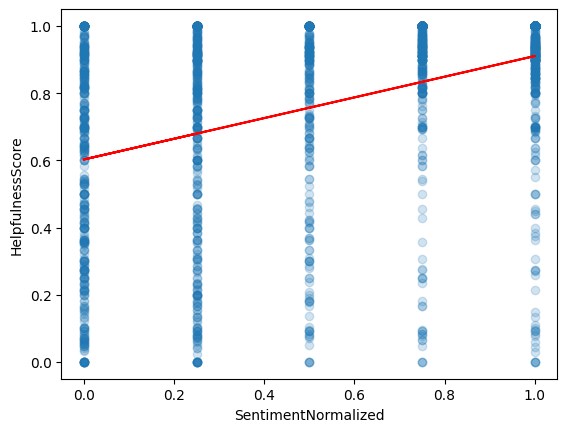

In [57]:
def run_bert_sentiment_analysis():
    import torch
    from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
    from tqdm import tqdm

    # Sample (for execution speed)
    # keep random_state=73 to have the same results as the sample available for
    # download
    df_sampled = df_filtered.sample(n=2000, random_state=73)
    print(f"Reviews sampled: {df_sampled.shape[0]}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    def bert_sentiment_score(text):
        # handle empty text
        if not isinstance(text, str) or not text.strip():
            return np.nan
        result = sentiment_pipeline(text[:512])[0] # BERT limit is 512 tokens
        # result['label'] will be "1 star", ..., "5 stars"
        score = int(result['label'][0]) # take the first character
        return score

    # 1 to 5
    df_sampled['Sentiment'] = [
        bert_sentiment_score(text)
        for text in tqdm(df_sampled['Text'], desc="BERT sentiment")
    ]
    # 0.0 to 1.0 (0.0, 0.25, 0.5, ...)
    df_sampled['SentimentNormalized'] = (df_sampled['Sentiment'] - 1) / 4

    perform_linear_regression(df_sampled, 'SentimentNormalized', 'HelpfulnessScore')

while True:
    execute_bert = input("Execute BERT for sentiment analysis (yes/no)? WARNING: Might take up to 30 minutes on a CPU (a few seconds on a T4 GPU). It's recommended to enter 'no' if you don't have a cuda-capable GPU, and you'll get the exact same result showed in the notebook (if you keep the random_state=73).\n*: ")
    if execute_bert.lower() not in ["yes", "no"]:
        print("Enter 'yes' or 'no'.")
        continue
    break

execute_bert = True if execute_bert.lower() == "yes" else False

if execute_bert:
    run_bert_sentiment_analysis()

The relationship is a bit stronger than with VADER Sentiment analysis ($R^2 ≃ 0.16$, using a sample of $n=2000$; using $n=1000$ with the same `random_state=73`, $R^2 ≃ 0.17$). Nonetheless, it's still a pretty weak linear relationship, and there's the possibility of $R^2$ being higher because of the discrete sentiment scoring (BERT outputs discrete values: 1, 2, 3, 4 and 5, which are then normalized to 0, 0.25, 0.50, 0.75 and 1.0). You can see the helpfulness score accumulates more and more in the upper values as you approach the highest possible sentiment score.

## Conclusion

Even in the first practices (P1, P2, P3), the descriptive statistics analysis, data exploration and plotting indicated there was no linear relationship between any of the variables. In this practice (P5), multiple linear models were tested, and none indicated a decent linear relationship between two variables. Even text complexity analysis (Flesch reading ease, type-token ratio, among other techniques) were tested separate from this practice (all of them had really low $R^2$).

The sentiment of a review vs its helpfulness score seems to be the strongest linear relationship there is between two variables in the `Amazon Fine Foods Reviews` dataset, with an $R^2$ of between $0.125$ (VADER Sentiment) and $0.17$ (BERT Multilingual Uncased), depending on the method used to analyze sentiment.

# (!) Post-analysis

There was a really obvious relationship I didn't notice for some reason: Score and Helpfulness Score. In the correlation matrix, there's a 0.37 Pearson coefficient for Score vs Helpfulness Score. Let's do a quick linear model.

Score vs. HelpfulnessScore
R^2: 0.1365, Coefficient: 0.08694


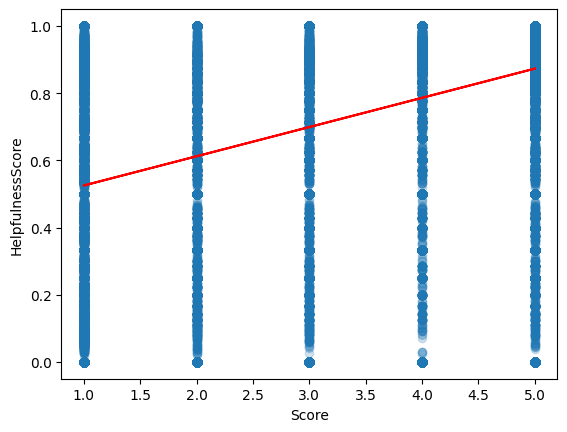

In [58]:
perform_linear_regression(df, 'Score', 'HelpfulnessScore')

There's a weak linear relationship ($R^2 ≃ 0.137$) between the score given by a review to the product and its helpfulness score ($\text{positive votes} / \text{total votes}$). It's stronger than *Sentiment vs Helpfulness Score* using VADER Sentiment Analysis, but weaker than *Sentiment vs Helpfulness Score* using BERT. Nonetheless, the conclusion is still the same (no strong linear relationship in the dataset).